In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

In [10]:
df = pd.read_excel(r"C:\Users\CHAITANYA\Documents\BTP\input_signal.xlsx")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.nn import ModuleList

class LIFNeuronModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LIFNeuronModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.threshold = nn.Parameter(torch.tensor(1.0))  # Learnable threshold

    def forward(self, x):
        mem_pot = self.linear(x)
        spikes = (mem_pot >= self.threshold).float()
        return spikes
    
    
    
class MultiHeadGraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads):
        super(MultiHeadGraphConvolution, self).__init__()
        self.num_heads = num_heads
        self.convs = ModuleList([nn.Conv1d(input_dim, output_dim, 1) for _ in range(num_heads)])

    def forward(self, x, adj):
        # Shape: [batch_size, num_heads * output_dim, sequence_length]
        out = torch.cat([conv(x) for conv in self.convs], dim=1)
        
        # Example einsum for batched matrix multiplication
        out = torch.einsum('bhc,bh->bc', out, adj)

        return F.relu(out)

class SpikeBasedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SpikeBasedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.fc(h)
        return out

class SpikeBasedFCVoting(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SpikeBasedFCVoting, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        out = self.fc(x)
        votes = out.sum(dim=1)  # Summing spikes for voting
        return votes

class EEGSpikeModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_heads, num_classes):
        super(EEGSpikeModel, self).__init__()
        self.lif = LIFNeuronModel(input_dim, output_dim)
        self.graph_conv = MultiHeadGraphConvolution(output_dim, output_dim, num_heads)
        self.lstm = SpikeBasedLSTM(output_dim, hidden_dim, output_dim)
        self.fc_voting = SpikeBasedFCVoting(output_dim, num_classes)

    def forward(self, x, adj):
        x = self.lif(x)
        x = x.unsqueeze(2)  # Add channel dimension
        x = self.graph_conv(x, adj)
        x = self.lstm(x)
        votes = self.fc_voting(x)
        return votes

# Load the dataset


# Separate features and target
X = df.iloc[:, :-1].values  # EEG signals (features)
y = df.iloc[:, -1].values   # Target (labels)

# Check and convert target variable to numerical if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)  # Ensure y_tensor is of type torch.long

# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


# Parameters
# Example dataset dimensions
# Example dataset dimensions
num_samples = 313856  # Adjust as per your dataset size
input_dim = 22
sequence_length = 256  # Adjust according to your actual sequence length
output_dim = 1
num_heads = 4

# Create dummy data (replace with your actual dataset loading)
X_tensor = torch.randn(num_samples, input_dim, sequence_length)
adj = torch.randn(num_samples, num_heads)  # Example adjacency matrix

# Instantiate the model
model = MultiHeadGraphConvolution(input_dim, output_dim, num_heads)

# Example forward pass
output = model(X_tensor, adj)
print(output.shape)  # Example output shape

# Ensure shapes match for the einsum operation
print(f"out shape: {output.shape}, adj shape: {adj.shape}")

# Example training loop (replace with your actual training loop)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Dummy training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_tensor, adj)
    loss = criterion(output, y_tensor)  # Use y_tensor as the target tensor
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 10284433408 bytes.

In [2]:

# Load the dataset
file_path = r"C:\Users\CHAITANYA\Documents\BTP\input_signal.xlsx"
df = pd.read_excel(file_path)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.nn import ModuleList


# Separate features and target
X = df.iloc[:, :-1].values  # EEG signals (features)
y = df.iloc[:, -1].values   # Target (labels)

# Convert target variable to numerical if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Ensure X_tensor is of type float32
y_tensor = torch.tensor(y, dtype=torch.long)     # Ensure y_tensor is of type long

# Create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Define a function to split the dataset into chunks
def get_dataloader(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Model definitions
class LIFNeuronModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LIFNeuronModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.threshold = nn.Parameter(torch.tensor(1.0))  # Learnable threshold

    def forward(self, x):
        mem_pot = self.linear(x)
        spikes = (mem_pot >= self.threshold).float()
        return spikes

class MultiHeadGraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads):
        super(MultiHeadGraphConvolution, self).__init__()
        self.num_heads = num_heads
        self.convs = ModuleList([nn.Conv1d(input_dim, output_dim, 1) for _ in range(num_heads)])
        self.bn = nn.BatchNorm1d(num_heads * output_dim)  # Batch Normalization

    def forward(self, x, adj):
        out = torch.cat([conv(x) for conv in self.convs], dim=1)
        out = self.bn(out)  # Apply Batch Normalization
        out = torch.einsum('bhc,bh->bc', out, adj)
        return F.relu(out)

class SpikeBasedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SpikeBasedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.fc(h)
        return out

class SpikeBasedFCVoting(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SpikeBasedFCVoting, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        out = self.fc(x)
        return out

class EEGSpikeModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_heads, num_classes):
        super(EEGSpikeModel, self).__init__()
        self.lif = LIFNeuronModel(input_dim, output_dim)
        self.graph_conv = MultiHeadGraphConvolution(output_dim, output_dim, num_heads)
        self.lstm = SpikeBasedLSTM(output_dim, hidden_dim, output_dim)
        self.fc_voting = SpikeBasedFCVoting(output_dim, num_classes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x, adj):
        x = self.lif(x)
        x = x.unsqueeze(2)  # Add channel dimension
        x = self.graph_conv(x, adj)
        x = self.dropout(x)  # Apply dropout
        x = self.lstm(x)
        votes = self.fc_voting(x)
        return votes

# Model instantiation
input_dim = 22
output_dim = 1  # Adjusted to match hidden_dim
hidden_dim = 64
num_heads = 4
num_classes = 2

model = EEGSpikeModel(input_dim, output_dim, hidden_dim, num_heads, num_classes)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 1
batch_size = 16

data_loader = get_dataloader(dataset, batch_size, shuffle=True)

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    total_loss = 0

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        adj = torch.randn(X_batch.size(0), num_heads)  # Example adjacency matrix
        output = model(X_batch, adj)
        
        # Debugging: Print the shape of the output tensor
        
        
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples * 100

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/1], Loss: 0.6932, Accuracy: 49.88%


In [44]:
df.head()

,# EEG Fp1-LE,EEG F3-LE,EEG C3-LE,EEG P3-LE,EEG O1-LE,EEG F7-LE,EEG T3-LE,EEG T5-LE,EEG Fz-LE,EEG Fp2-LE,...,EEG O2-LE,EEG F8-LE,EEG T4-LE,EEG T6-LE,EEG Cz-LE,EEG Pz-LE,EEG A2-A1,EEG 23A-23R,EEG 24A-24R,OUTPUT
0,-0.000025,-0.000024,-0.000016,-0.000019,-0.000009,-0.000011,0.000013,-0.000010,-0.000057,-0.000044,...,-0.000023,-0.000022,-0.000031,-0.000014,-0.000024,-0.000013,0.000001,5.500420e-07,2.500191e-07,H
1,-0.000024,-0.000030,-0.000027,-0.000024,-0.000013,-0.000027,-0.000015,-0.000015,0.000025,-0.000042,...,-0.000027,-0.000044,-0.000034,-0.000018,-0.000025,-0.000028,-0.000025,8.500649e-07,5.000381e-08,H
2,-0.000023,-0.000026,-0.000028,-0.000019,-0.000011,-0.000034,-0.000030,-0.000013,0.000041,-0.000032,...,-0.000020,-0.000041,-0.000021,-0.000015,-0.000019,-0.000032,-0.000030,7.500572e-07,1.500114e-07,H
3,-0.000022,-0.000013,-0.000016,-0.000009,-0.000004,-0.000027,-0.000019,-0.000008,-0.000027,-0.000022,...,-0.000009,-0.000015,-0.000001,-0.000011,-0.000011,-0.000020,-0.000011,3.500267e-07,2.500191e-07,H
4,-0.000023,-0.000009,-0.000008,-0.000011,-0.000001,-0.000020,0.000003,-0.000010,-0.000085,-0.000028,...,-0.000007,0.000004,0.000004,-0.000013,-0.000016,-0.000008,0.000007,1.500114e-07,2.500191e-07,H


## BASELINE CORRECTION

In [13]:
def baseline_correction(data, baseline_window=(0, 100)):
    """
    Perform baseline correction on EEG data.

    Parameters:
    - data: EEG data in numpy array format (channels x samples)
    - baseline_window: Tuple indicating the baseline window (start, end)

    Returns:
    - corrected_data: Baseline corrected EEG data
    """
    baseline_data = data[:, baseline_window[0]:baseline_window[1]]
    baseline_mean = np.mean(baseline_data, axis=1, keepdims=True)
    corrected_data = data - baseline_mean
    return corrected_data

## BANDPASS FILTER

In [14]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    """
    Design a Butterworth bandpass filter.


    Returns:
    - b, a: Numerator (b) and denominator (a) polynomials of the IIR filter
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a


In [15]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply Butterworth bandpass filter to EEG data.

    Parameters:
    - data: EEG data in numpy array format (channels x samples)
    - lowcut: Lower cutoff frequency of the bandpass filter
    - highcut: Higher cutoff frequency of the bandpass filter
    - fs: Sampling frequency
    - order: Order of the filter (default=5)

    Returns:
    - filtered_data: Bandpass filtered EEG data
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

In [16]:
# Convert DataFrame to numpy array
df_without_target = df.iloc[:, :-1]

# Transpose the DataFrame to have the format "channels x samples"
eeg_data = df_without_target.values.T

In [17]:
# Define parameters
baseline_window = (0, 100)  # Define baseline correction window
lowcut = 1                  # Lower cutoff frequency for bandpass filter
highcut = 40                # Higher cutoff frequency for bandpass filter
fs = 250                    # Sampling frequency

# Perform baseline correction

baseline_corrected_data = baseline_correction(eeg_data, baseline_window)

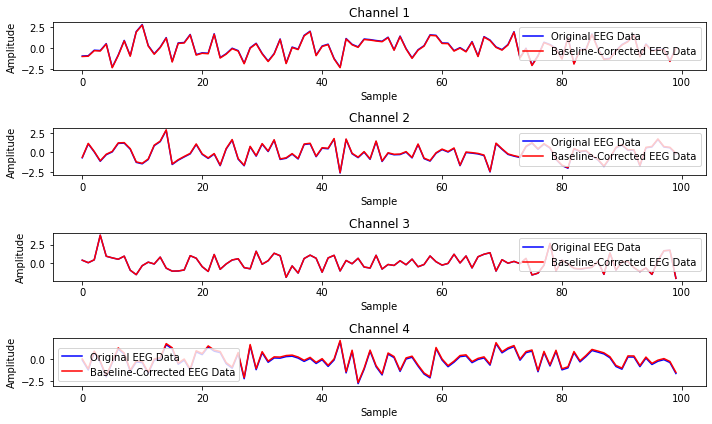

In [18]:
import numpy as np
import matplotlib.pyplot as plt

baseline_window = (0, 100) 
lowcut = 1                 
highcut = 40            
fs = 250                 

# Define baseline correction function
def baseline_correction(data, baseline_window=(0, 100)):
    """
    Perform baseline correction on EEG data.

    Parameters:
    - data: EEG data in numpy array format (channels x samples)
    - baseline_window: Tuple indicating the baseline window (start, end)

    Returns:
    - corrected_data: Baseline corrected EEG data
    """
    baseline_data = data[:, baseline_window[0]:baseline_window[1]]
    baseline_mean = np.mean(baseline_data, axis=1, keepdims=True)
    corrected_data = data - baseline_mean
    return corrected_data

num_channels = 4
num_samples = 100
eeg_data = np.random.randn(num_channels, num_samples)

baseline_corrected_data = baseline_correction(eeg_data, baseline_window)

plt.figure(figsize=(10, 6))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(eeg_data[i], color='b', label='Original EEG Data')
    plt.plot(baseline_corrected_data[i], color='r', label='Baseline-Corrected EEG Data')
    plt.title(f'Channel {i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Perform bandpass filtering
filtered_data = butter_bandpass_filter(baseline_corrected_data, lowcut, highcut, fs)

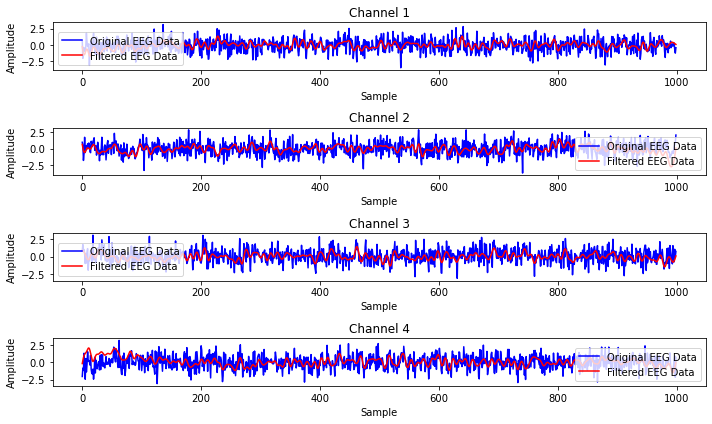

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data
fs = 500 
lowcut = 1 
highcut = 50 

num_channels = 4
num_samples = 1000
eeg_data = np.random.randn(num_channels, num_samples)

# Apply the Butterworth bandpass filter to the EEG data
filtered_data = butter_bandpass_filter(eeg_data, lowcut, highcut, fs)

# Plot original and filtered EEG data
plt.figure(figsize=(10, 6))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(eeg_data[i], color='b', label='Original EEG Data')
    plt.plot(filtered_data[i], color='r', label='Filtered EEG Data')
    plt.title(f'Channel {i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
plt.tight_layout()
plt.show()


In [21]:
def create_dataframe_from_transposed_data(filtered_data):
    # Assuming transposed_data is a 2D array where each row corresponds to a channel
    # and each column corresponds to a sample
    num_channels, num_samples = filtered_data.shape
    dff = pd.DataFrame(filtered_data.T)  # Transpose back to samples x channels format
    dff.columns = [f'Channel_{i+1}' for i in range(num_channels)]
    return dff

In [22]:
dfff = create_dataframe_from_transposed_data(filtered_data)

In [23]:
# Create a dictionary mapping current column names to new column names
new_column_names = {
    'Channel_1'  :'EEG Fp1-LE',
    'Channel_2'  : 'EEG F3-LE',
    'Channel_3':  'EEG C3-LE',
    'Channel_4':  'EEG P3-LE',
    'Channel_5':  'EEG O1-LE',
    'Channel_6':  'EEG F7-LE',
    'Channel_7':  'EEG T3-LE',
    'Channel_8':  'EEG T5-LE',
    'Channel_9':  'EEG Fz-LE',
    'Channel_10': 'EEG Fp2-LE',
    'Channel_11': 'EEG F4-LE',
    'Channel_12': 'EEG C4-LE',
    'Channel_13': 'EEG P4-LE',
    'Channel_14': 'EEG O2-LE',
    'Channel_15': 'EEG F8-LE',
    'Channel_16': 'EEG T4-LE',
    'Channel_17': 'EEG T6-LE',
    'Channel_18': 'EEG Cz-LE',
    'Channel_19': 'EEG Pz-LE',
    'Channel_20': 'EEG A2-A1',
    'Channel_21': 'EEG 23A-23R',
    'Channel_22': 'EEG 24A-24R'
    
}

# Rename the columns using the rename() method
dfff = dfff.rename(columns=new_column_names)


In [24]:
target_column = df.iloc[:, -1]

# Add the target column to dfff
dfff['OUTPUT'] = target_column

In [87]:
dfff.head()

,EEG Fp1-LE,EEG F3-LE,EEG C3-LE,EEG P3-LE,OUTPUT
0,0.128566,-0.116889,0.294168,0.347949,H
1,0.106594,-0.485204,0.333398,-0.262565,H
2,0.097257,-0.808917,0.366230,-0.773756,H
3,0.109531,-1.050986,0.390409,-1.113390,H
4,0.145700,-1.188173,0.408437,-1.254769,H


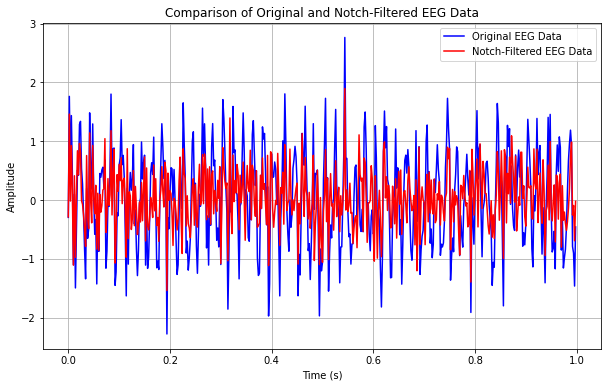

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

fs = 500 

t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
eeg_data = np.sin(2 * np.pi * 50 * t) + 0.5 * np.random.randn(len(t))

f0 = 50 
Q = 30 

b, a = signal.iirnotch(f0, Q, fs)

eeg_data_notch_filtered = signal.filtfilt(b, a, eeg_data)

plt.figure(figsize=(10, 6))
plt.plot(t, eeg_data, color='b', label='Original EEG Data')
plt.plot(t, eeg_data_notch_filtered, color='r', label='Notch-Filtered EEG Data')
plt.title('Comparison of Original and Notch-Filtered EEG Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [90]:
eeg_data_notch_filtered

array([-0.28725852,  1.4597086 , -0.01872706,  0.92519648,  0.10314997,
       -1.10874607,  0.41154234, -0.97684242,  0.07995447,  0.8371081 ,
        0.42662257,  0.96127758,  0.80064854, -0.01234855, -0.0746036 ,
       -0.25884194, -0.50457602, -0.79015377,  0.75505278, -0.29881963,
       -0.48695466,  1.14022162, -0.0153904 , -0.38922902,  0.92667687,
        0.04420674, -0.23435171,  0.24886304, -0.83588955,  0.11369375,
       -0.85824644,  0.09476354, -0.20727515, -0.09766567,  0.16803222,
        0.19035151,  1.04295287, -0.55201623, -0.2472187 ,  0.36329883,
       -0.09087763,  0.08802122,  1.17784289, -0.25445675,  0.46172978,
        0.86318632, -1.07326668, -0.5889038 ,  0.43006573,  0.1475909 ,
        0.6052874 ,  0.32774281,  0.71860895, -0.06260133,  0.33296776,
        0.37138378, -0.12239059, -0.97351267,  0.87162859, -0.65735806,
        0.13668687,  0.07083498, -0.50236336, -0.31338633,  0.49857144,
       -0.43724047,  0.23011737, -0.15089465, -0.58750654, -0.39

## ICA 

C:\Users\CHAITANYA\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


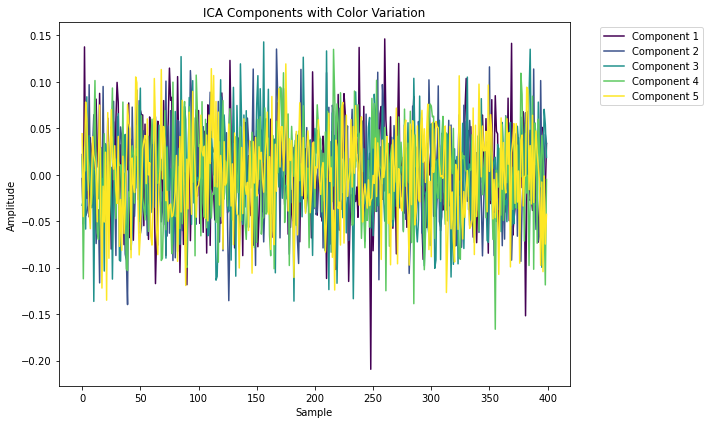

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

num_channels = 7
num_samples = 400
eeg_data = np.random.randn(num_channels, num_samples)

ica = FastICA(n_components=5, random_state=0)
ica_components = ica.fit_transform(eeg_data.T) 

colors = plt.cm.viridis(np.linspace(0, 1, ica_components.shape[1]))

plt.figure(figsize=(10, 6))
for i in range(ica_components.shape[1]):
    plt.plot(ica_components[:, i], color=colors[i], label=f'Component {i+1}')
    plt.title('ICA Components with Color Variation')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [92]:
dfff

,EEG Fp1-LE,EEG F3-LE,EEG C3-LE,EEG P3-LE,OUTPUT
0,0.128566,-0.116889,0.294168,0.347949,H
1,0.106594,-0.485204,0.333398,-0.262565,H
2,0.097257,-0.808917,0.366230,-0.773756,H
3,0.109531,-1.050986,0.390409,-1.113390,H
4,0.145700,-1.188173,0.408437,-1.254769,H
...,...,...,...,...,...
995,0.262429,0.657569,1.774272,0.008486,H
996,0.145633,0.648121,1.653827,0.024153,H
997,0.072600,0.496686,1.270598,0.024094,H
998,0.017995,0.240299,0.662935,-0.002319,H


## DOWN SAMPLING


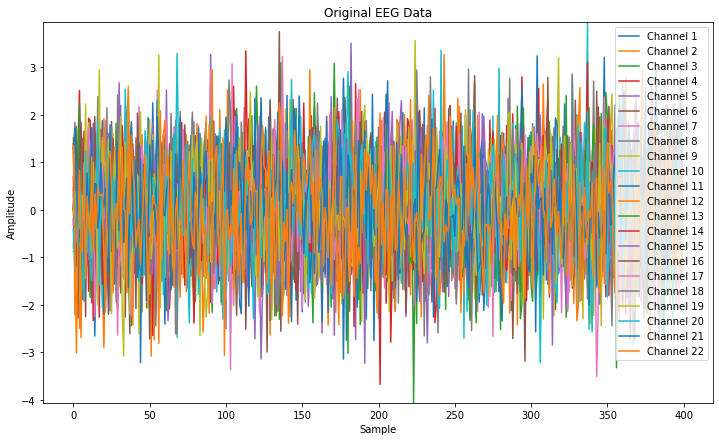

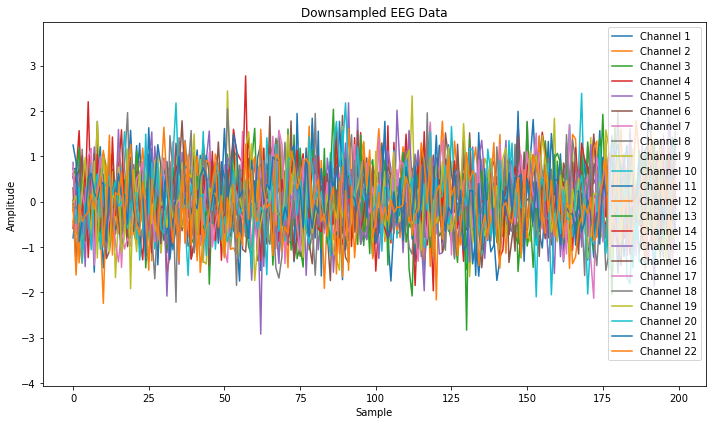

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

original_fs = 250
target_fs = 100   

num_channels = 22
num_samples = 400
eeg_data = np.random.randn(num_channels, num_samples)

downsampling_factor = original_fs // target_fs

downsampled_eeg_data = np.zeros((num_channels, num_samples // downsampling_factor))
for i in range(num_channels):
    downsampled_eeg_data[i] = resample(eeg_data[i], num_samples // downsampling_factor)

# Calculate the y-axis limits for both original and downsampled data
original_ylim = (np.min(eeg_data), np.max(eeg_data))
downsampled_ylim = (np.min(downsampled_eeg_data), np.max(downsampled_eeg_data))

# Determine the maximum ylim for both plots
combined_ylim = (min(original_ylim[0], downsampled_ylim[0]), max(original_ylim[1], downsampled_ylim[1]))

# Plot the original data
plt.figure(figsize=(12, 7))
for i in range(num_channels):
    plt.plot(eeg_data[i], label=f'Channel {i+1}')
plt.title('Original EEG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.ylim(combined_ylim)  # Set y-axis limits
plt.legend()

# Plot the downsampled data
plt.figure(figsize=(10, 6)) 
for i in range(num_channels):
    plt.plot(downsampled_eeg_data[i], label=f'Channel {i+1}')
plt.title('Downsampled EEG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.ylim(combined_ylim)  # Set y-axis limits
plt.legend()

plt.tight_layout()
plt.show()


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

original_fs = 250
target_fs = 100   


num_channels = 22
num_samples = 400
eeg_data = np.random.randn(num_channels, num_samples)

downsampling_factor = original_fs // target_fs

downsampled_eeg_data = np.zeros((num_channels, num_samples // downsampling_factor))
for i in range(num_channels):
    downsampled_eeg_data[i] = resample(eeg_data[i], num_samples // downsampling_factor)

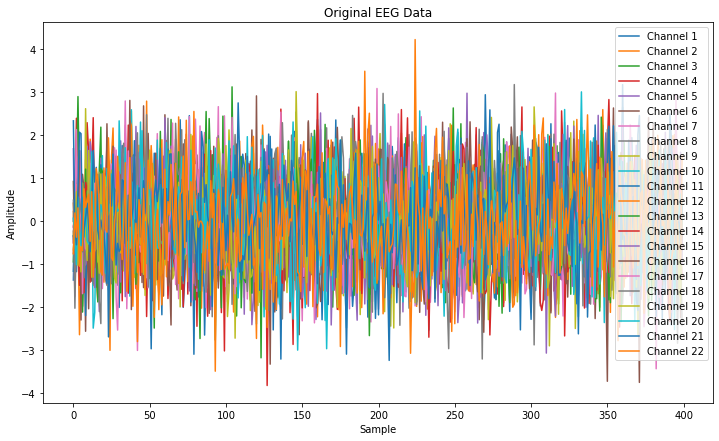

In [94]:
plt.figure(figsize=(12, 7))

for i in range(num_channels):
    plt.plot(eeg_data[i], label=f'Channel {i+1}')
plt.title('Original EEG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()


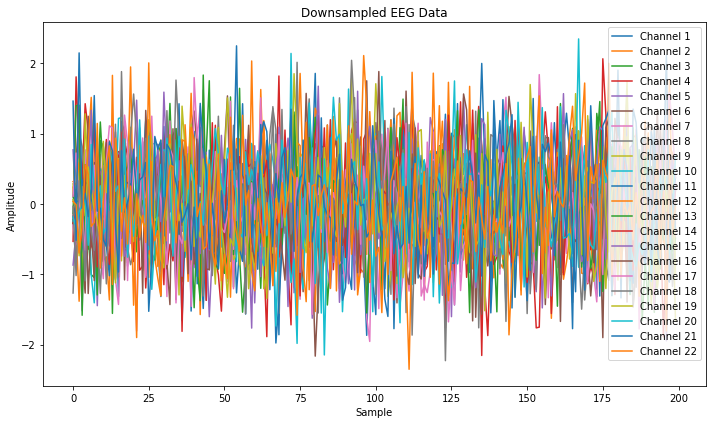

In [95]:
# Plot downsampled EEG data
plt.figure(figsize=(10, 6)) 
for i in range(num_channels):
    plt.plot(downsampled_eeg_data[i], label=f'Channel {i+1}')
plt.title('Downsampled EEG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# FFT

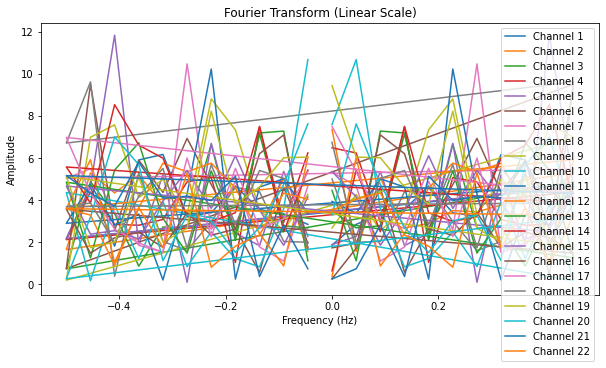

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Load the "dfff" dataset (replace this with your actual loading code)
# Assuming "dfff" is a multichannel EEG dataset with shape (num_samples, num_channels)
dfff_data = eeg_data  # Load your dataset here

# Compute Fourier transform for each channel
fft_data = np.fft.fft(dfff_data, axis=0)
freqs = np.fft.fftfreq(dfff_data.shape[0])

# Plot linear scale for the first 22 channels
plt.figure(figsize=(10, 5))
for i in range(22):  # Loop over the first 22 channels
    plt.plot(freqs, np.abs(fft_data[:, i]), label=f'Channel {i+1}')
plt.title('Fourier Transform (Linear Scale)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


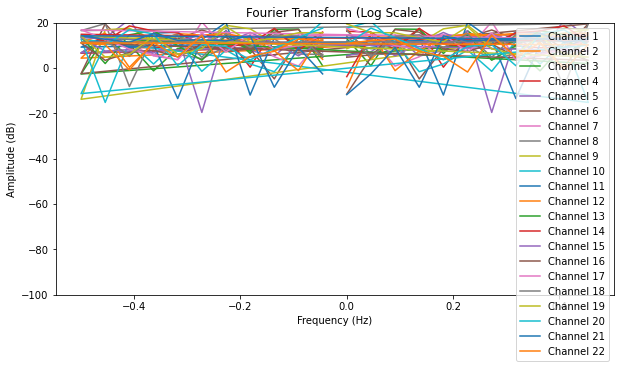

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Load the "dfff" dataset (replace this with your actual loading code)
# Assuming "dfff" is a multichannel EEG dataset with shape (num_samples, num_channels)
dfff_data = eeg_data  # Load your dataset here

# Compute Fourier transform for each channel
fft_data = np.fft.fft(dfff_data, axis=0)
freqs = np.fft.fftfreq(dfff_data.shape[0])

# Plot logarithmic scale for the first 22 channels
plt.figure(figsize=(10, 5))
for i in range(22):  # Loop over the first 22 channels
    plt.plot(freqs, 20 * np.log10(np.abs(fft_data[:, i])), label=f'Channel {i+1}')
plt.title('Fourier Transform (Log Scale)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.ylim([-100, 20])  # Limit the y-axis for better visualization
plt.legend()
plt.show()


# WAVLET TRANSFORM 

In [19]:
dfff = dfff.iloc[:, :-1]

# Transpose the DataFrame to have the format "channels x samples"
eeg_data = dfff.values.T

It seems that the CWT is returning a 3-dimensional array (127, 4, 1000), where:

127 represents the number of scales (or frequencies),
4 represents the number of channels or signals in the EEG data, and
1000 represents the number of time points.
To plot this data using plt.imshow(), you need to decide how you want to represent it visually. Here are a few options:

Average over channels: You can average the wavelet coefficients over channels to obtain a 2D representation, then plot it using plt.imshow().
Select a specific channel: You can select a specific channel and plot the wavelet coefficients for that channel.
Plot as a 3D surface: You can plot the wavelet coefficients as a 3D surface plot using mpl_toolkits.mplot3d.

In [21]:
import pywt

In [22]:
# Choose wavelet and scales
wavelet = 'morl'  # Morlet wavelet
scales = np.arange(1, 128)  # Range of scales

# Perform continuous wavelet transform
coefficients, frequencies = pywt.cwt(eeg_data, scales, wavelet)

# Average the wavelet coefficients over channels
avg_coeffs = np.mean(np.abs(coefficients), axis=1)

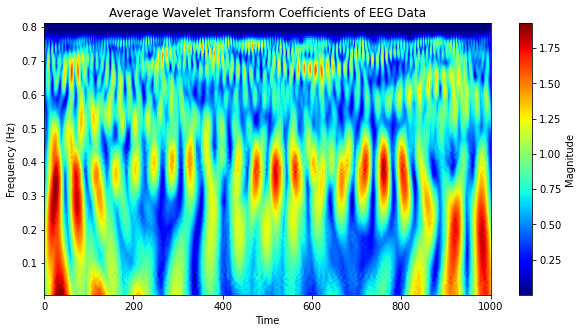

In [23]:
# Plot the averaged coefficients
plt.figure(figsize=(10, 5))
plt.imshow(avg_coeffs, extent=[0, len(eeg_data[0]), frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Average Wavelet Transform Coefficients of EEG Data')
plt.show()

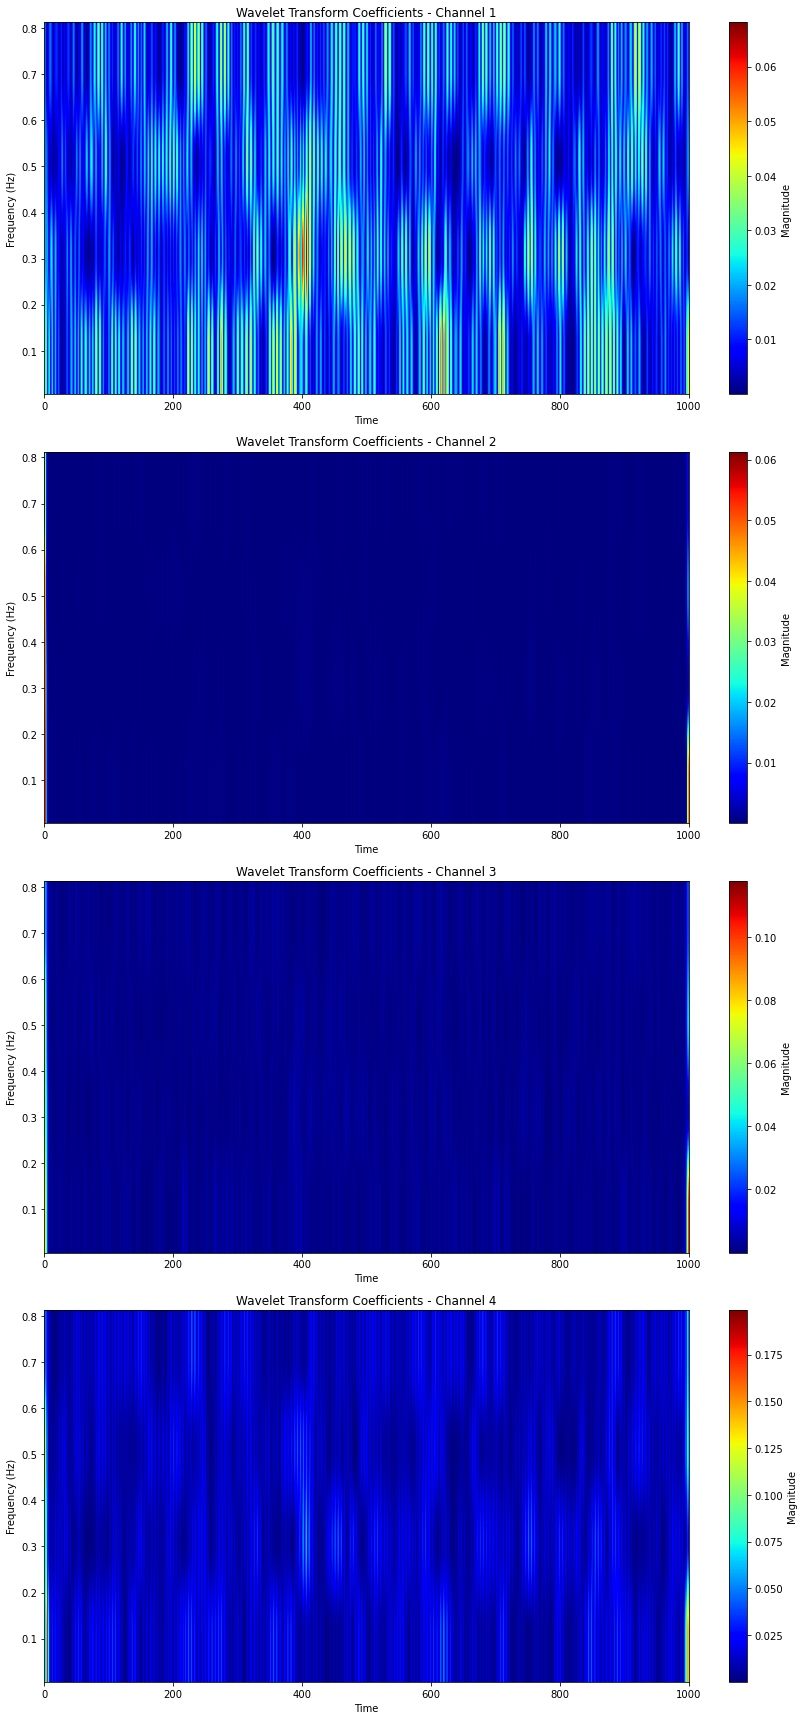

In [24]:
# Plot individual channel coefficients
num_channels = len(eeg_data)
plt.figure(figsize=(12, 6*num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i+1)
    plt.imshow(np.abs(coefficients[i]), extent=[0, len(eeg_data[0]), frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Wavelet Transform Coefficients - Channel {i+1}')
plt.tight_layout()
plt.show()


# SCALOGRAM:

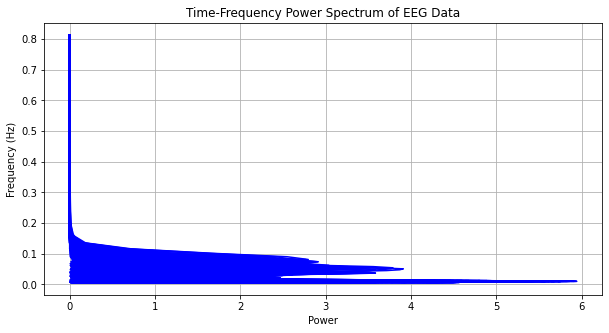

In [26]:
# Average the scalogram over time
avg_scalogram = np.mean(scalogram, axis=1)

# Plot time-frequency power spectrum
plt.figure(figsize=(10, 5))
plt.plot(avg_scalogram, frequencies, color='blue')
plt.xlabel('Power')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Power Spectrum of EEG Data')
plt.grid(True)
plt.show()


# CSP

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.metrics import confusion_matrix

In [127]:
def2.head()

,# EEG Fp1-LE,EEG F3-LE,EEG C3-LE,EEG P3-LE,EEG O1-LE,EEG F7-LE,EEG T3-LE,EEG T5-LE,EEG Fz-LE,EEG Fp2-LE,...,EEG O2-LE,EEG F8-LE,EEG T4-LE,EEG T6-LE,EEG Cz-LE,EEG Pz-LE,EEG A2-A1,EEG 23A-23R,EEG 24A-24R,OUTPUT
0,-0.000025,-0.000024,-0.000016,-0.000019,-0.000009,-0.000011,0.000013,-0.000010,-0.000057,-0.000044,...,-0.000023,-0.000022,-0.000031,-0.000014,-0.000024,-0.000013,0.000001,5.500420e-07,2.500191e-07,0
1,-0.000024,-0.000030,-0.000027,-0.000024,-0.000013,-0.000027,-0.000015,-0.000015,0.000025,-0.000042,...,-0.000027,-0.000044,-0.000034,-0.000018,-0.000025,-0.000028,-0.000025,8.500649e-07,5.000381e-08,0
2,-0.000023,-0.000026,-0.000028,-0.000019,-0.000011,-0.000034,-0.000030,-0.000013,0.000041,-0.000032,...,-0.000020,-0.000041,-0.000021,-0.000015,-0.000019,-0.000032,-0.000030,7.500572e-07,1.500114e-07,0
3,-0.000022,-0.000013,-0.000016,-0.000009,-0.000004,-0.000027,-0.000019,-0.000008,-0.000027,-0.000022,...,-0.000009,-0.000015,-0.000001,-0.000011,-0.000011,-0.000020,-0.000011,3.500267e-07,2.500191e-07,0
4,-0.000023,-0.000009,-0.000008,-0.000011,-0.000001,-0.000020,0.000003,-0.000010,-0.000085,-0.000028,...,-0.000007,0.000004,0.000004,-0.000013,-0.000016,-0.000008,0.000007,1.500114e-07,2.500191e-07,0


In [3]:
def2 = df

In [4]:
df['OUTPUT'] = df['OUTPUT'].map({'H': 0, 'MDD': 1})

In [5]:
X = def2.iloc[:, :-1].values
y = def2.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
# Define CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
y_train = y_train.astype(int)
y_test = y_test.astype(int)

NameError: name 'train_test_split' is not defined

In [ ]:
def2.shape

In [ ]:
X.shape

In [ ]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=1, batch_size=64, validation_split=0.1)
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print('Test Accuracy:', accuracy)

3924/3924 [==============================] - 31s 8ms/step
Classification Report:


C:\Users\CHAITANYA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CHAITANYA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CHAITANYA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67     62748
           1       0.00      0.00      0.00     62795

    accuracy                           0.50    125543
   macro avg       0.25      0.50      0.33    125543
weighted avg       0.25      0.50      0.33    125543

Confusion Matrix:
[[62748     0]
 [62795     0]]


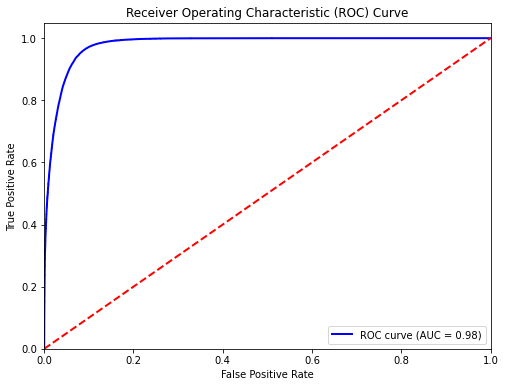

In [130]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for each class
y_pred_probs = model.predict(X_test_reshaped)

# Convert probabilities to predicted classes by selecting the class with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute precision, recall, F1 score, and confusion matrix
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))



# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [131]:
X = def2.iloc[:, :-1].values
y = def2.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
# Define 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [132]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print('Test Accuracy (1D CNN):', accuracy)


Epoch 1/10
3531/3531 [==============================] - 20s 5ms/step - loss: 0.1289 - accuracy: 0.9540 - val_loss: 0.0977 - val_accuracy: 0.9635
Epoch 2/10
3531/3531 [==============================] - 18s 5ms/step - loss: 0.0848 - accuracy: 0.9685 - val_loss: 0.0725 - val_accuracy: 0.9736
Epoch 3/10
3531/3531 [==============================] - 20s 6ms/step - loss: 0.0670 - accuracy: 0.9756 - val_loss: 0.0690 - val_accuracy: 0.9744
Epoch 4/10
3531/3531 [==============================] - 18s 5ms/step - loss: 0.0574 - accuracy: 0.9788 - val_loss: 0.0571 - val_accuracy: 0.9787
Epoch 5/10
3531/3531 [==============================] - 18s 5ms/step - loss: 0.0516 - accuracy: 0.9814 - val_loss: 0.0514 - val_accuracy: 0.9817
Epoch 6/10
3531/3531 [==============================] - 20s 6ms/step - loss: 0.0484 - accuracy: 0.9824 - val_loss: 0.0506 - val_accuracy: 0.9813
Epoch 7/10
3531/3531 [==============================] - 21s 6ms/step - loss: 0.0460 - accuracy: 0.9831 - val_loss: 0.0505 - val_ac

In [7]:
from keras.layers import LSTM, Dense
X = def2.iloc[:, :-1].values
y = def2.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:


# Train the model
model.fit(X_train_reshaped, y_train, epochs=1, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print('Test Accuracy (LSTM):', accuracy)


1962/1962 [==============================] - 10s 5ms/step - loss: 0.2097 - accuracy: 0.9158
Test Accuracy (LSTM): 0.9157904982566833


1962/1962 [==============================] - 10s 5ms/step


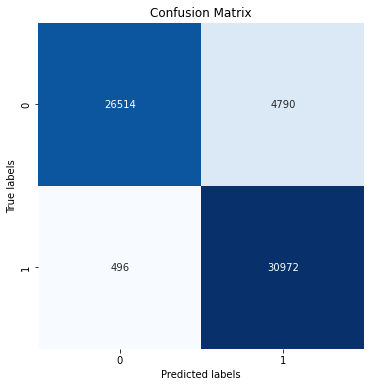

In [9]:
y_pred_probs = model.predict(X_test_reshaped)

# Apply threshold to get predicted classes
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1962/1962 [==============================] - 8s 4ms/step
Precision: 0.87
Recall (Sensitivity): 0.98
Specificity: 0.85


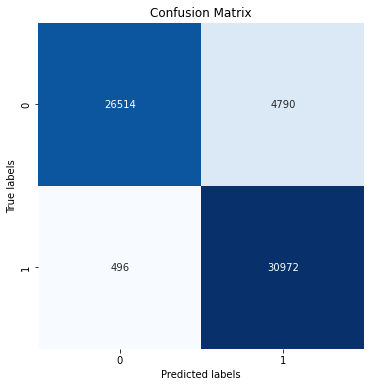

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict probabilities
y_pred_probs = model.predict(X_test_reshaped)

# Apply threshold to get predicted classes
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract true positives, false positives, true negatives, and false negatives
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate precision, recall (sensitivity), and specificity
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = TN / (TN + FP)

# Print the scores
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## SPIKE ENCODING

In [4]:
import numpy as np
dfff = np.array(dfff)

NameError: name 'dfff' is not defined

In [41]:
dfff.shape

(1000, 5)

In [123]:
eeg_data.shape

(22, 400)

In [122]:
def2.shape

(1000, 5)

In [ ]:
import numpy as np

def spike_encoding(data, threshold):
    spike_trains = []
    for channel_data in data:
        # Skip non-numeric data
        if not np.issubdtype(channel_data.dtype, np.number):
            continue
        # Apply spike encoding with threshold
        spikes = (channel_data > threshold).astype(int)
        spike_trains.append(spikes)
    return np.array(spike_trains) 

threshold = 0 

# Convert EEG data to spike trains using AER approach
spike_trains = spike_encoding(eeg_data, threshold)


In [ ]:
spike_trains

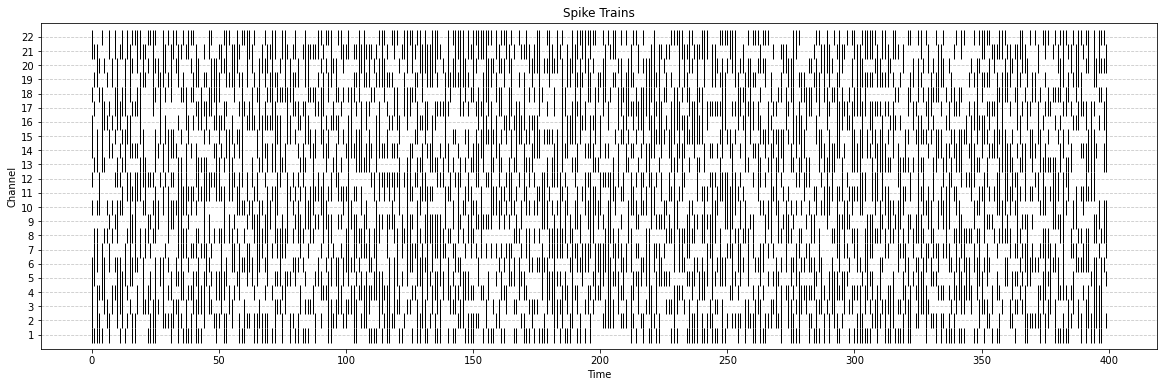

In [91]:
plt.figure(figsize=(20, 6))
for i, channel_spikes in enumerate(spike_trains):
    spike_indices = np.where(channel_spikes == 1)[0]
    plt.plot(spike_indices, np.full_like(spike_indices, i), '|', color='black', markersize=15)
plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('Spike Trains')
plt.ylim(-1, len(spike_trains))
plt.yticks(np.arange(len(spike_trains)), np.arange(1, len(spike_trains) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## SNN Initialization:

In [64]:
import numpy as np

def initialize_snn(num_neurons, sparsity_ratio):

    num_connections = int(num_neurons * sparsity_ratio)

    snn_reservoir = np.random.rand(num_neurons, num_neurons, num_neurons)
    
    for i in range(num_neurons):

        indices_to_keep = np.random.choice(num_neurons, min(num_connections, num_neurons), replace=False)

        snn_reservoir[i, :, :] *= np.isin(np.arange(num_neurons), indices_to_keep)[:, np.newaxis]
    
    return snn_reservoir

num_neurons = 22

sparsity_ratio = 2.5 

snn_reservoir = initialize_snn(num_neurons, sparsity_ratio)
# initializes an SNN reservoir with random weights and giving sparsity ratio by setting a proportion of connections to zero.

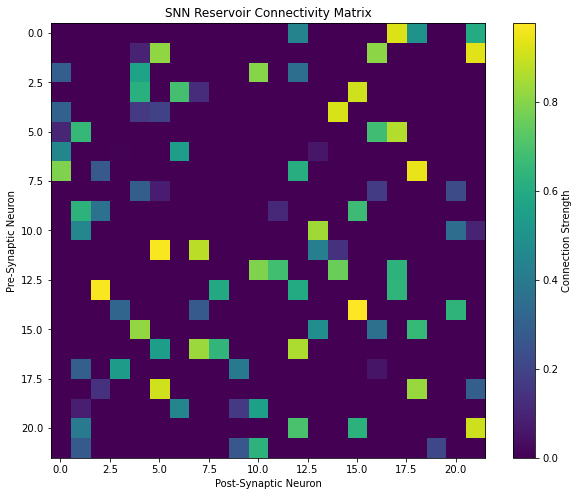

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_snn(num_neurons, sparsity_ratio):
    num_connections = int(num_neurons * sparsity_ratio)
    snn_reservoir = np.random.rand(num_neurons, num_neurons)
    
    for i in range(num_neurons):
        indices_to_keep = np.random.choice(num_neurons, min(num_connections, num_neurons), replace=False)
        snn_reservoir[i, :] *= np.isin(np.arange(num_neurons), indices_to_keep)
    
    return snn_reservoir

def plot_connectivity_matrix(snn_reservoir):
    plt.figure(figsize=(10, 8))
    plt.imshow(snn_reservoir, cmap='viridis', origin='upper', interpolation='none')
    plt.colorbar(label='Connection Strength')
    plt.xlabel('Post-Synaptic Neuron')
    plt.ylabel('Pre-Synaptic Neuron')
    plt.title('SNN Reservoir Connectivity Matrix')
    plt.grid(False)
    plt.show()

num_neurons = 22
sparsity_ratio = 0.2

snn_reservoir = initialize_snn(num_neurons, sparsity_ratio)
plot_connectivity_matrix(snn_reservoir)


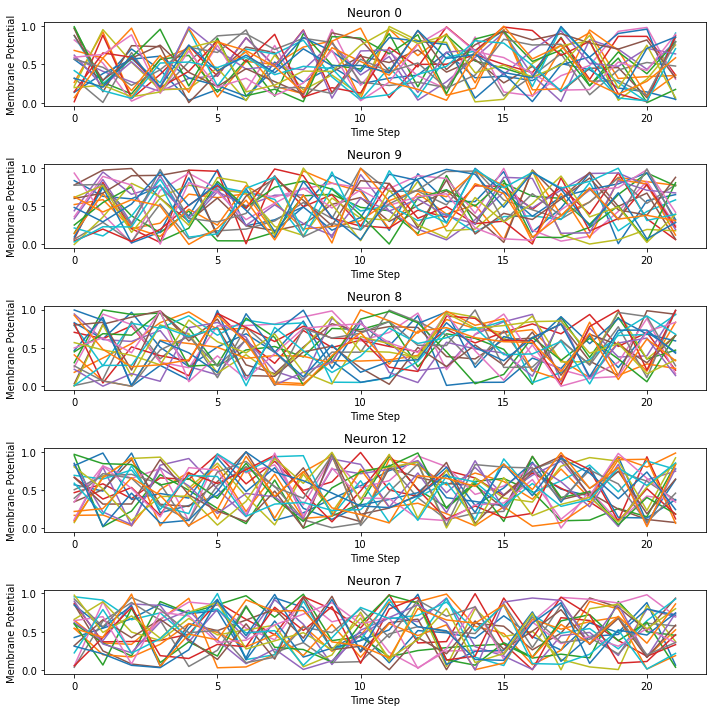

In [65]:
import matplotlib.pyplot as plt

num_neurons, _, num_timepoints = snn_reservoir.shape
num_slices = min(5, num_neurons) 

fig, axes = plt.subplots(num_slices, figsize=(10, 2*num_slices))

for i in range(num_slices):

    neuron_idx = np.random.randint(num_neurons)

    axes[i].plot(snn_reservoir[neuron_idx].T)
    axes[i].set_title(f'Neuron {neuron_idx}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Membrane Potential')

plt.tight_layout()
plt.show()


In [67]:
snn_reservoir

array([[[5.65782681e-01, 2.89816778e-01, 7.00896715e-01, ...,
         1.94041458e-01, 1.42242240e-01, 4.82148390e-02],
        [2.66713447e-01, 9.23039218e-01, 7.50881054e-02, ...,
         3.17473975e-01, 3.41893327e-01, 3.55331272e-01],
        [9.73532937e-01, 2.66389734e-01, 1.18078404e-01, ...,
         5.82629657e-01, 4.20371829e-03, 1.75786374e-01],
        ...,
        [4.20060541e-01, 1.58928736e-01, 5.92748171e-02, ...,
         6.43225708e-02, 2.67260727e-02, 7.04960783e-01],
        [3.20669917e-01, 2.04891600e-01, 6.12875164e-01, ...,
         6.82207388e-02, 7.08474868e-01, 8.57290147e-01],
        [6.90490626e-02, 5.82791270e-01, 1.60560693e-01, ...,
         1.14130929e-01, 2.81207184e-01, 5.86300877e-01]],

       [[3.00399326e-02, 3.82327140e-01, 7.37540616e-02, ...,
         1.63982614e-01, 8.28231828e-01, 8.64259191e-01],
        [6.34939816e-01, 5.30537670e-01, 8.67798233e-01, ...,
         2.74940125e-01, 6.00877134e-01, 8.06998870e-01],
        [3.73486412e-01, 

# Data Preprocessing:
Load the raw EEG data and apply preprocessing steps as described in the paper, such as downsampling, baseline removal, notch filtering, bandpass filtering, and independent component analysis (ICA) for artifact removal.
Spike Encoding:
Convert the preprocessed EEG data into spike trains using the address event representation (AER) approach, a simplified adaptation of the threshold-based representation (TBR) technique.
SNN Initialization:
Initialize the SNN reservoir (SNNr) using the sparse weight connection rule (SWC) with a sparsity ratio (SW R) of 2.5. This creates a three-dimensional SNNr structure that mimics the shape of the brain.
SNN Reservoir:
Implement the SNN reservoir using the leaky-integrate-and-fire (LIF) neuron model. The LIF neuron model describes the behavior of a neuron as it integrates incoming signals and fires an action potential when the membrane potential crosses a predefined threshold.
LSTM Network Integration:
Integrate the SNNr with a long short-term memory (LSTM) network to enhance the comprehension and classification of depression. The LSTM network processes the output from the SNNr to improve the classification performance.
Training and Classification: 
Train the hybrid SNN-LSTM network using the synaptic time-dependent plasticity (STDP) learning rule. The STDP rule adjusts synaptic weights based on the precise timing of spikes between pre-synaptic and post-synaptic neurons.
Use the trained model for classification and prediction, achieving exceptional accuracy in classification, with average rates of 98% and 96% for eyes-closed and eyes-open states, respectively.

## SNN Reservoir: 

In [68]:
import numpy as np

class LIFNeuron:
    def __init__(self, num_neurons, time_steps, membrane_time_constant=20, threshold=1):
        self.num_neurons = num_neurons
        self.time_steps = time_steps
        self.membrane_time_constant = membrane_time_constant
        self.threshold = threshold
        
        # Initialize membrane potential and spike trains
        self.membrane_potential = np.zeros((num_neurons, time_steps))
        self.spike_trains = np.zeros((num_neurons, time_steps))
    
    def integrate(self, input_spike_train):
        # Integrate incoming signals into the membrane potential
        for t in range(1, self.time_steps):
           
            self.membrane_potential[:, t] = (1 - 1 / self.membrane_time_constant) * self.membrane_potential[:, t - 1] + input_spike_train[:, t]
            
            spiked_neurons = np.where(self.membrane_potential[:, t] >= self.threshold)[0]
            self.spike_trains[spiked_neurons, t] = 1
            self.membrane_potential[spiked_neurons, t] = 0
    
    def get_spike_trains(self):
   
        return self.spike_trains

num_neurons = 22
time_steps = 307200
input_spike_train = np.random.rand(num_neurons, time_steps)

lif_neuron_model = LIFNeuron(num_neurons, time_steps)

lif_neuron_model.integrate(input_spike_train)

spike_trains = lif_neuron_model.get_spike_trains()


In [74]:
print("spike encodings :")
print(spike_trains)

spike encodings :
[[0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


C:\Users\CHAITANYA\AppData\Local\Temp\ipykernel_13596\1808084201.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


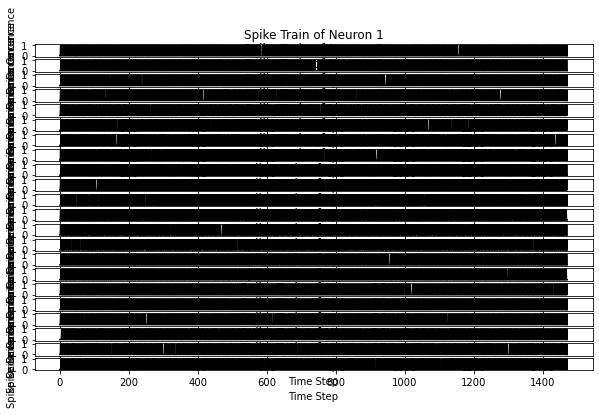

In [70]:
plt.figure(figsize=(10, 6))
for i in range(num_neurons):
    plt.subplot(num_neurons, 1, i + 1)
    plt.stem(spike_trains[i], linefmt='black', markerfmt='black', basefmt=' ', use_line_collection=True)
    plt.title(f'Spike Train of Neuron {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Spike Occurrence')
    plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

In [59]:
snn_reservoir.shape

(22, 22, 22)

In [60]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

labels = ['H','MDD']


labels_numerical = np.array([0 if label == 'H' else 1 for label in labels])


snn_reservoir_reshaped = snn_reservoir.reshape(snn_reservoir.shape[0], -1)

assert len(labels_numerical) == snn_reservoir_reshaped.shape[0], "Number of samples in labels doesn't match the data"

lstm_model = Sequential([
    LSTM(units=64, input_shape=(snn_reservoir_reshaped.shape[1], 1)),
    Dense(units=1, activation='sigmoid')  # Assuming binary classification
])

lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.fit(snn_reservoir_reshaped, labels_numerical, epochs=2, batch_size=32, validation_split=0.1)


AssertionError: Number of samples in labels doesn't match the data

In [34]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow-addons --upgrade


Note: you may need to restart the kernel to use updated packages.


# THE END

# STDP - 7TH SEMESTER

In [1]:
from tensorflow_addons.layers import SpikingRNN

C:\Users\CHAITANYA\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


ImportError: cannot import name 'SpikingRNN' from 'tensorflow_addons.layers' (C:\Users\CHAITANYA\anaconda3\lib\site-packages\tensorflow_addons\layers\__init__.py)

In [2]:
from tensorflow_addons.rnn.spiking import SpikingRNN

ModuleNotFoundError: No module named 'tensorflow_addons.rnn.spiking'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow_addons.rnn.spiking import SpikingRNN

# Define Hybrid SNN-LSTM Network Architecture
model = tf.keras.Sequential([
    SpikingRNN(units=64, return_sequences=True),
    LSTM(units=64),
    Dense(units=num_classes, activation='softmax')
])

# Define the STDP Learning Rule (Custom Training Loop)
@tf.function
def custom_train_step(inputs, targets, model, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Implement STDP learning rule to adjust synaptic weights
    # Modify synaptic weights based on the precise timing of spikes
    # This involves updating the weights of connections between SNN and LSTM layers

# Prepare Training Data
# (Assuming you have prepared your training data as X_train and y_train)

# Compile the Model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Custom Training Loop
for epoch in range(num_epochs):
    for inputs, targets in train_dataset:
        custom_train_step(inputs, targets, model, optimizer)

# Evaluate Model Performance
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Use the Trained Model for Prediction
# (Assuming you have new data prepared as X_pred)
predictions = model.predict(X_pred)


In [ ]:
import tensorflow_addons as tfa
print(tfa.__version__)

In [ ]:
snn_reservoir_reshaped.shape

In [ ]:
import pandas as pd

# Assume 'snn_reservoir' is the output from the SNN reservoir
# Shape of 'snn_reservoir': (num_samples, num_neurons, num_timepoints)

# Reshape the SNN reservoir output for DataFrame creation
num_samples, num_neurons, num_timepoints = snn_reservoir.shape
snn_reservoir_reshaped = snn_reservoir.reshape(num_samples, -1)

# Create a DataFrame from the reshaped SNN reservoir
df_snn_reservoir = pd.DataFrame(snn_reservoir_reshaped)

# Optionally, you can set column names if needed
# Example: df_snn_reservoir.columns = [f'Neuron_{i}' for i in range(num_neurons * num_timepoints)]

# Now 'df_snn_reservoir' is a DataFrame representation of the SNN reservoir output
